In [2]:
import arviz as az
import bambi as bmb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats
from scipy.optimize import minimize
from toolz import partial
import preliz as pz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%matplotlib inline
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False
FIGSIZE = (7, 4)

# Binomial vs BetaBinomial

In [3]:
def beta_binomial_mean(n, alpha, beta):
    return (n * alpha) / (alpha + beta)

def beta_binomial_variance(n, alpha, beta):
    t1 = (n * alpha * beta) / (alpha + beta) ** 2
    t2 = (alpha + beta + n) / (alpha + beta + 1)
    return t1 * t2

def beta_variance(alpha, beta):
    num = alpha * beta
    denum = ((alpha + beta) ** 2) * (alpha + beta + 1)
    return num / denum

In [4]:
n = 24
alpha = 13
beta = 6

p = alpha / (alpha + beta)

In [5]:
x = np.arange(n + 1)
betabin_rv = pm.BetaBinomial.dist(alpha=alpha, beta=beta, n=n)
# Binomial pdf given log-probability of the Binomial dist.
betabin_pdf = np.exp(pm.logp(betabin_rv, x).eval())

In [6]:
bin_pdf = stats.binom.pmf(x, n, p)

<Axes: >

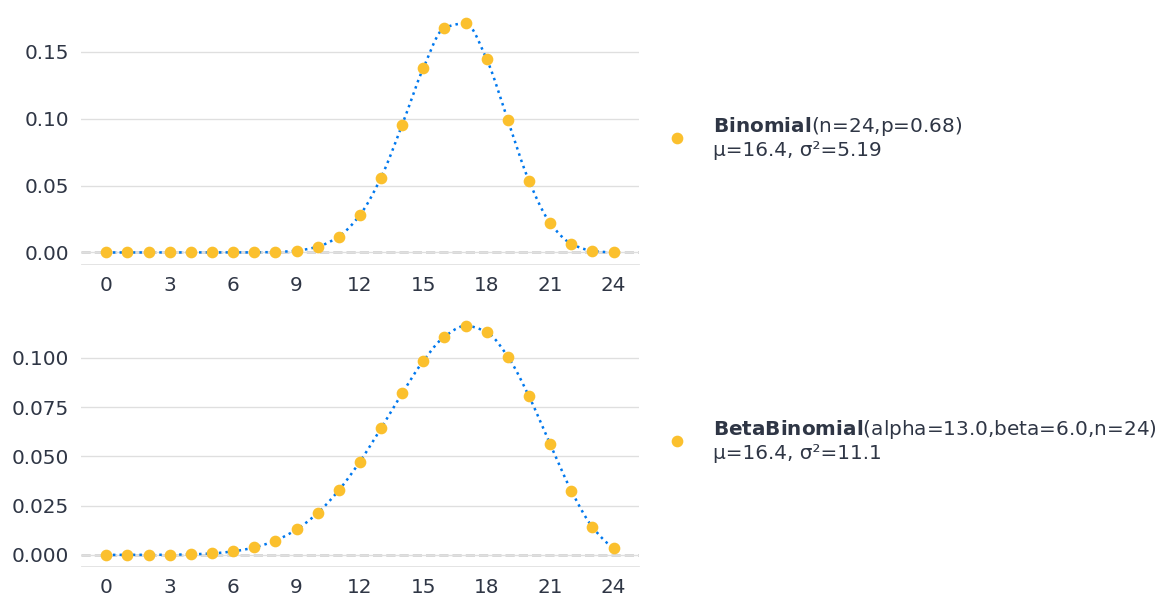

In [7]:
fig, axes = plt.subplots(figsize=(6, 6), nrows=2, ncols=1, layout="constrained")
pz.Binomial(n=n, p=p).plot_pdf(moments=["m", "v"], ax=axes[0])
pz.BetaBinomial(n=n, alpha=alpha, beta=beta).plot_pdf(moments=["m", "v"], ax=axes[1])

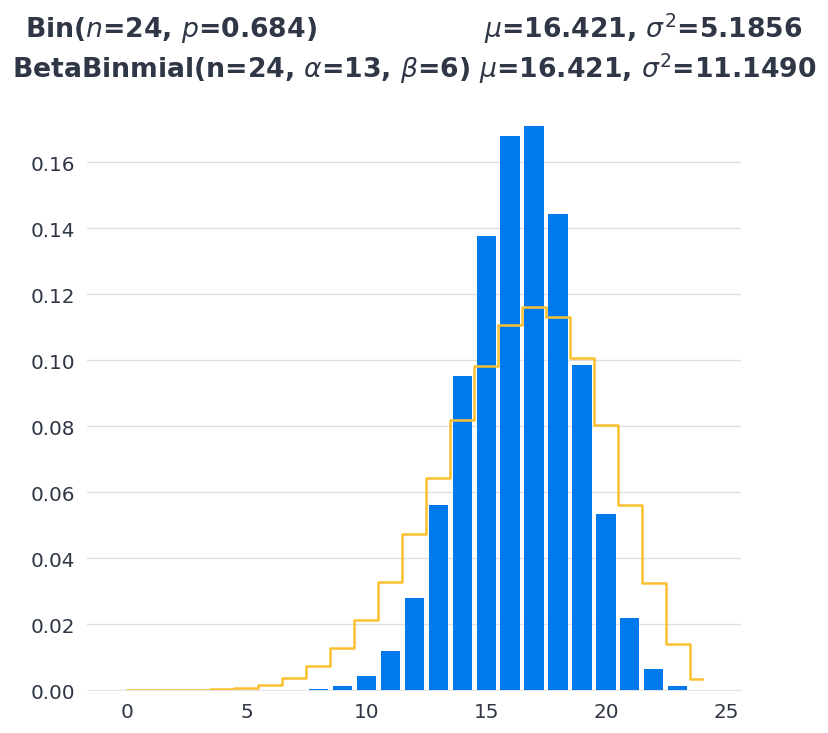

In [8]:
fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
ax.bar(x, bin_pdf)
ax.set(
    title=fr"Bin($n$={n}, $p$={p})" + "\n" +fr"$\mu$={n * p:.3f}, $\sigma^2$={n * p * (1- p):.4f}")

ax.step(x, betabin_pdf, where="mid", color="C1")
ax.set(
    title=(
        fr"Bin($n$={n}, $p$={p:.3f})" + f"{' ':18}" +fr"$\mu$={n * p:.3f}, $\sigma^2$={n * p * (1- p):.4f}" + 
        "\n"
        fr"BetaBinmial(n={n}, $\alpha$={alpha}, $\beta$={beta}) " + 
        fr"$\mu$={beta_binomial_mean(n, alpha, beta):.3f}, $\sigma^2$={beta_binomial_variance(n, alpha, beta):.4f}"))
plt.show()

## Poisson Likekihood
* maximum likelihood estimate of $\lambda$ assuming $X \sim \mathrm{Poisson}(\lambda)$:
    * optimization- minimize the negative log likelihood
    * direct estimate- the mean observed value
    * pymc model- estimating the intercept (log mean value)
    
* Poisson distribution puts more certainty (overestimate) around the bulk of the distribution \
and underestimate at the tails

In [9]:
toy_df = pd.read_csv("../data/toy_counts.csv")
toy_df.head()

,values
0,3
1,4
2,9
3,1
4,7


In [10]:
x = toy_df["values"].to_numpy()

In [11]:

def minimize_poisson_logp(x: np.ndarray[float], init_val: float, optimizer_method: str='L-BFGS-B') -> float:
    """λ estimate for poisson likelihood"""
    def poisson_negative_logp(λ: float, x: np.ndarray[float]) -> float:
        """poisson negative log probability"""
        return - (stats.poisson.logpmf(x, mu=λ).sum())
    fun = partial(poisson_negative_logp, x=x)
    bounds = [(0, np.inf)]  # positive value
    opt_res = minimize(fun, init_val, bounds=bounds, method=optimizer_method)
    λ_star = opt_res.x[0]  # feature weight vector
    loss = opt_res.fun
    return λ_star, loss

In [12]:
λ_star, loss = minimize_poisson_logp(x=x, init_val=3)
print(f"estimated λ:{λ_star:10.3f}\nlog-likelihood: {-loss:.3f}")

estimated λ:     6.108
log-likelihood: -1380.567


In [13]:
x.mean()

6.108

In [14]:
toy_model = bmb.Model(formula="values ~ 1", data=toy_df, family="poisson", link="log")
toy_model

       Formula: values ~ 1
        Family: poisson
          Link: mu = log
  Observations: 500
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


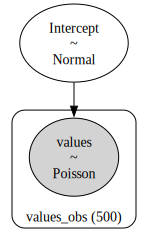

In [15]:
toy_idata = toy_model.fit(chains=4, random_seed=1234)
toy_model.graph()

In [16]:
az.summary(toy_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.809,0.018,1.777,1.844,0.0,0.0,1734.0,2962.0,1.0


In [17]:
λ_bayes = np.exp(toy_idata.posterior["Intercept"]).mean().item()
λ_bayes

6.104028490604843

# Admission Rate by Sex in 6 departments

In [18]:
df_berkely = pd.read_csv("../data/UCBadmit.csv", dtype={"dept": "category", "gender": "category"})
df_berkely["p"] = df_berkely["admit"] / df_berkely["applications"]
df_berkely = df_berkely.reset_index(drop=True)
df_berkely.head()

,dept,gender,admit,reject,applications,p
0,A,male,512,313,825,0.620606
1,A,female,89,19,108,0.824074
2,B,male,353,207,560,0.630357
3,B,female,17,8,25,0.680000
4,C,male,120,205,325,0.369231


In [19]:
trials = df_berkely["applications"].to_numpy()
admits = df_berkely["admit"].to_numpy()

In [20]:
dept, dept_idx = df_berkely["dept"].cat.categories, df_berkely["dept"].cat.codes
gender, gender_idx = df_berkely["gender"].cat.categories, df_berkely["gender"].cat.codes

## Binomial model for graduate admissions using PyMC
* Goal- estimate the effect of gender on admission rate
* model- Binomial likelihood

### Global (average) effect of gender for all departments
* the model is underdispersed
    * the observed values are not within the 95% HDI

In [21]:
admissions_coords = {"dept": dept, "gender": gender}

with pm.Model(coords=admissions_coords) as admission_naive_model:
    # prior
    β_gender = pm.Normal("β_gender", 0, 2, dims="gender")
    # p- estimator
    p_bin = pm.Deterministic("p", pm.math.sigmoid(β_gender))
    # Binomial likeihood
    pm.Binomial("admissions", p=p_bin[gender_idx], n=trials, observed=admits)

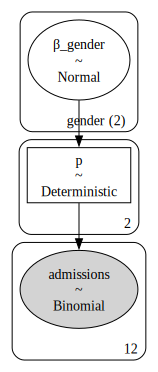

In [22]:
pm.model_to_graphviz(admission_naive_model)

In [23]:
with admission_naive_model:
    admission_naive_idata = pm.sample(chains=4, random_seed=1234)
    admission_naive_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(admission_naive_idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β_gender]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [admissions, β_gender]
Sampling: [admissions]


In [24]:
az.summary(admission_naive_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_gender[female],-0.831,0.051,-0.932,-0.741,0.001,0.001,3825.0,2797.0,1.0
β_gender[male],-0.220,0.038,-0.292,-0.150,0.001,0.000,4206.0,2876.0,1.0
p[0],0.304,0.011,0.283,0.323,0.000,0.000,3825.0,2797.0,1.0
p[1],0.445,0.009,0.427,0.463,0.000,0.000,4206.0,2876.0,1.0


In [25]:
# get mean and 95 HDI (lb, ub)
p_mean = admission_naive_idata.posterior["p"].mean(dim=("chain", "draw")).to_numpy()
p_qs = admission_naive_idata.posterior["p"].quantile(q=(0.025, 0.975), dim=("chain", "draw")).to_numpy()

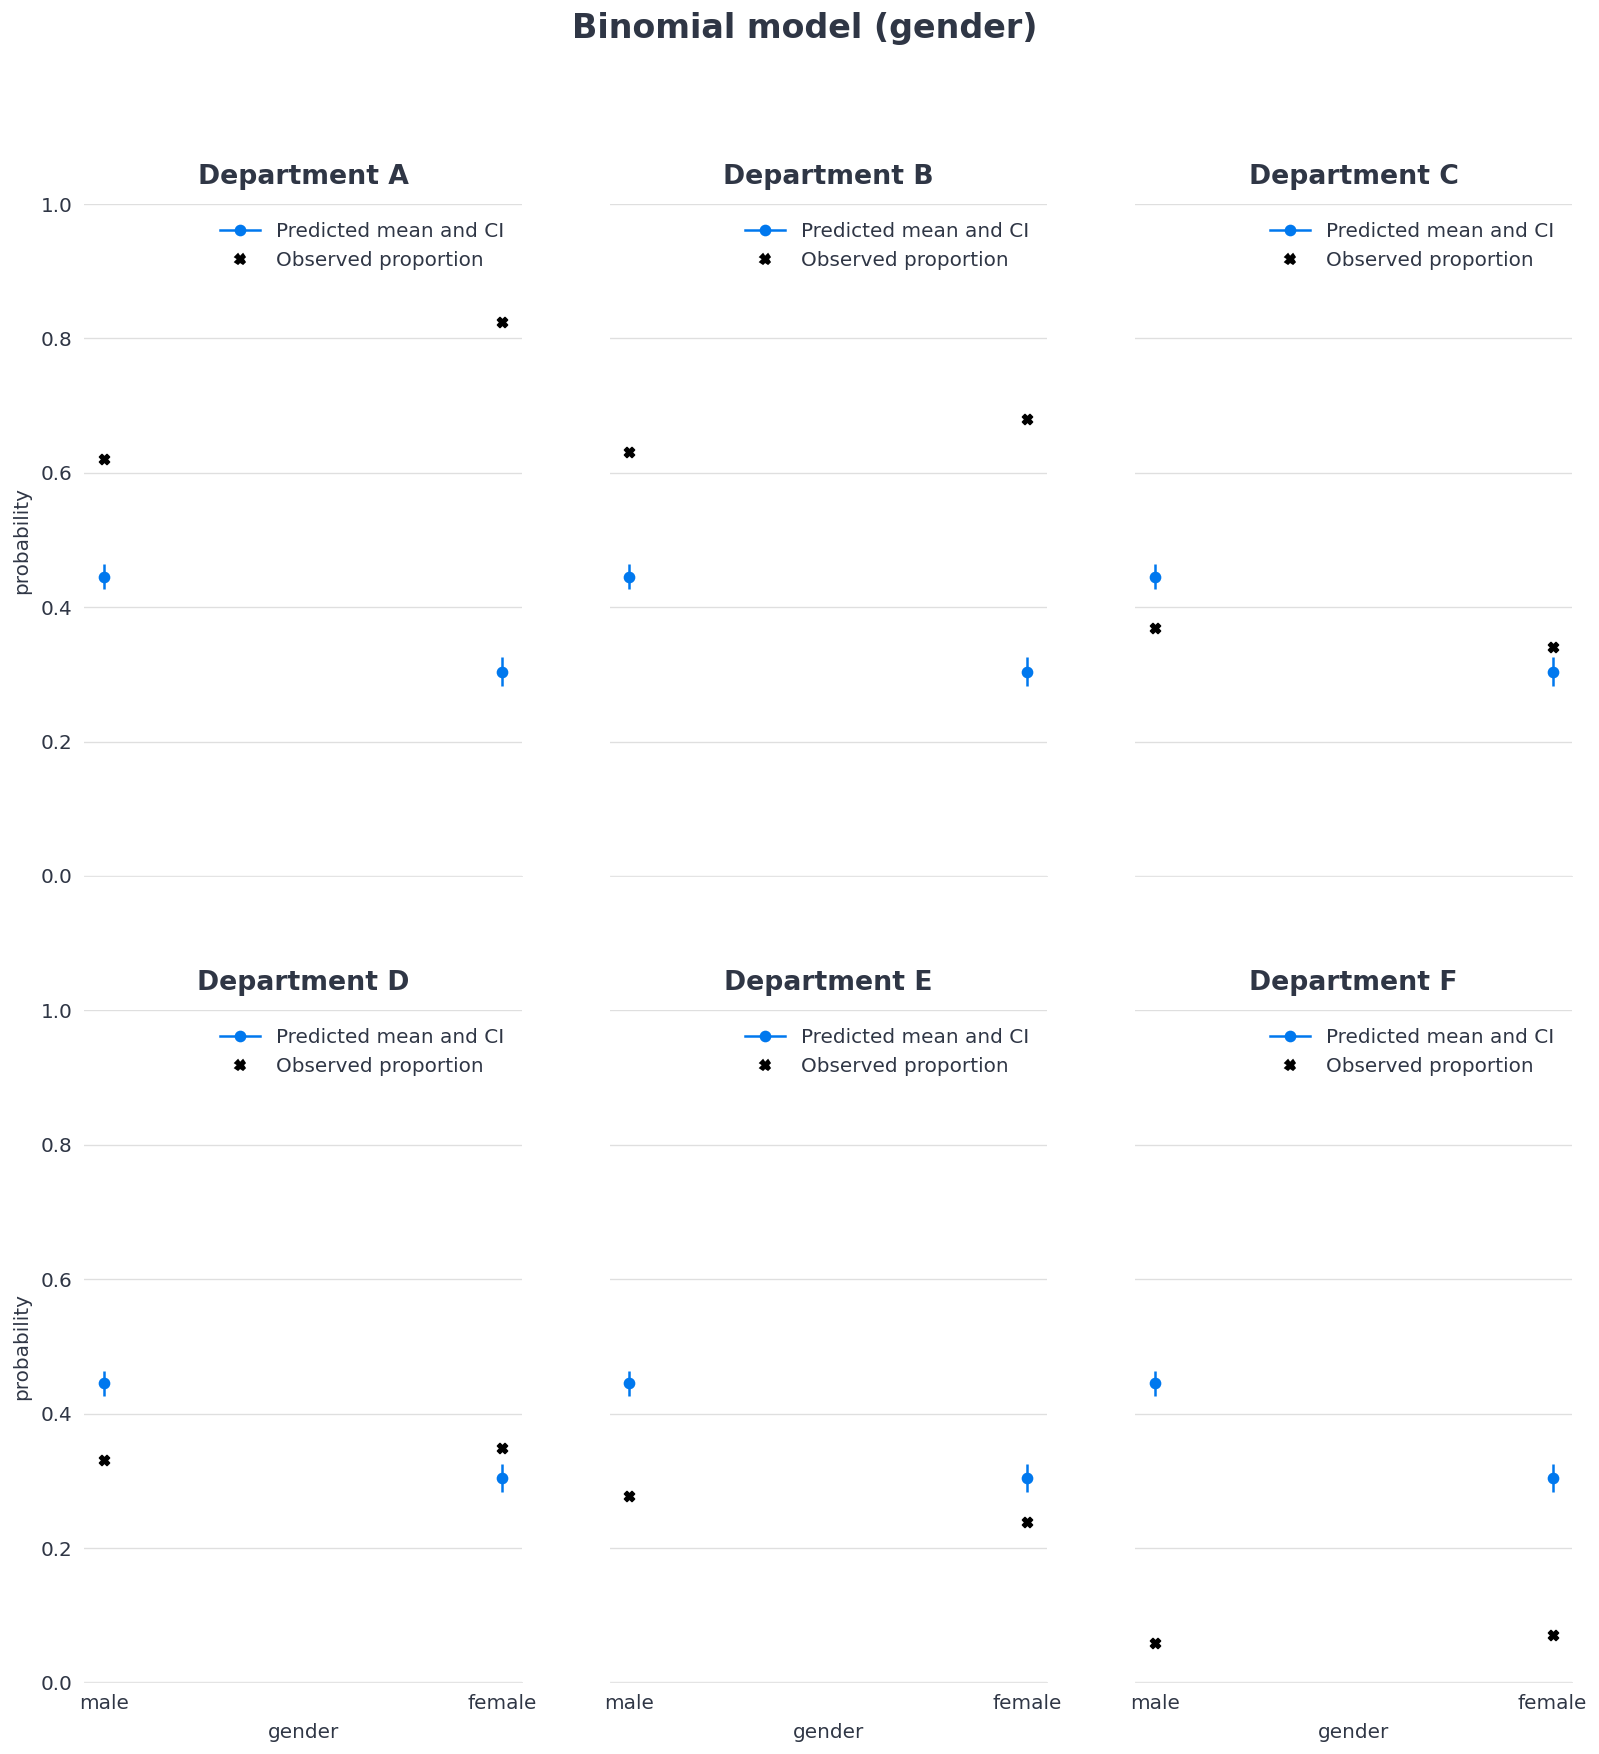

In [26]:
fig, axes = plt.subplots(figsize=(16, 16), nrows=2, ncols=3,  sharex=True, sharey=True)
for i, ((dept_name, dept_df), ax) in enumerate(zip(df_berkely.groupby("dept", observed=False)[["gender", "p"]], axes.ravel())):
    ax.scatter(x="gender", y="p", data=dept_df, marker="X", c="k", label="observed")
    ax.scatter(x=gender, y=p_mean, label="predicted")
    ax.vlines(x=gender, ymin=p_qs[0], ymax=p_qs[1], label="predicted")
    if i == 0:
        ax.set(title=f"Department {dept_name}", ylabel="probability", ylim=(0, 1))
    elif i == 3:
        ax.set(title=f"Department {dept_name}", xlabel="gender", ylabel="probability", ylim=(0, 1))
    elif i > 3:
        ax.set(title=f"Department {dept_name}", xlabel="gender")
    else:
        ax.set(title=f"Department {dept_name}")
    handles = [
    Line2D([], [], color="C0", marker="o", label="Predicted mean and CI"),
    Line2D([], [], color="black", lw=0, marker="X", label="Observed proportion")
    ]
    ax.legend(handles=handles);
fig.suptitle("Binomial model (gender)", fontsize=20);

### Local Effect of gender for each department
* the model is less underdispersed
    * most of the observed values are within the 95% HDI

In [27]:
with pm.Model(coords=admissions_coords) as admission_model:
    # prior
    β_gender = pm.Normal("β_gender", 0, 2, dims="gender")
    β_dept = pm.ZeroSumNormal("β_dept", dims="dept")
    # linear regression
    η = β_gender[gender_idx] + β_dept[dept_idx]
    p = pm.Deterministic("p", pm.math.sigmoid(η))
    # Binomial likeihood
    pm.Binomial("admissions", p=p, n=trials, observed=admits)

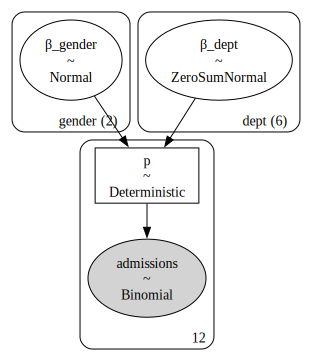

In [28]:
pm.model_to_graphviz(admission_model)

In [29]:
with admission_model:
    admission_idata = pm.sample(chains=4, random_seed=1234)
    admission_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(admission_idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β_gender, β_dept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [admissions, β_dept, β_gender]
Sampling: [admissions]


In [30]:
az.summary(admission_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_gender[female],-0.594,0.061,-0.707,-0.477,0.001,0.001,3819.0,3162.0,1.0
β_gender[male],-0.686,0.050,-0.782,-0.597,0.001,0.001,2940.0,2465.0,1.0
β_dept[A],1.264,0.072,1.133,1.402,0.001,0.001,3356.0,2996.0,1.0
β_dept[B],1.217,0.083,1.059,1.370,0.001,0.001,4380.0,3666.0,1.0
β_dept[C],0.008,0.072,-0.123,0.142,0.001,0.001,4522.0,3486.0,1.0
β_dept[D],-0.025,0.072,-0.160,0.109,0.001,0.001,4275.0,3597.0,1.0
β_dept[E],-0.463,0.088,-0.617,-0.292,0.001,0.001,4235.0,3390.0,1.0
β_dept[F],-2.002,0.130,-2.238,-1.762,0.003,0.002,2211.0,2453.0,1.0
p[0],0.641,0.016,0.610,0.669,0.000,0.000,6002.0,3445.0,1.0
p[1],0.661,0.022,0.620,0.703,0.000,0.000,3588.0,2915.0,1.0


In [31]:
p_mean2 = admission_idata.posterior["p"].mean(dim=("chain", "draw")).to_numpy()
p_qs2 = admission_idata.posterior["p"].quantile(q=(0.025, 0.975), dim=("chain", "draw")).to_numpy()

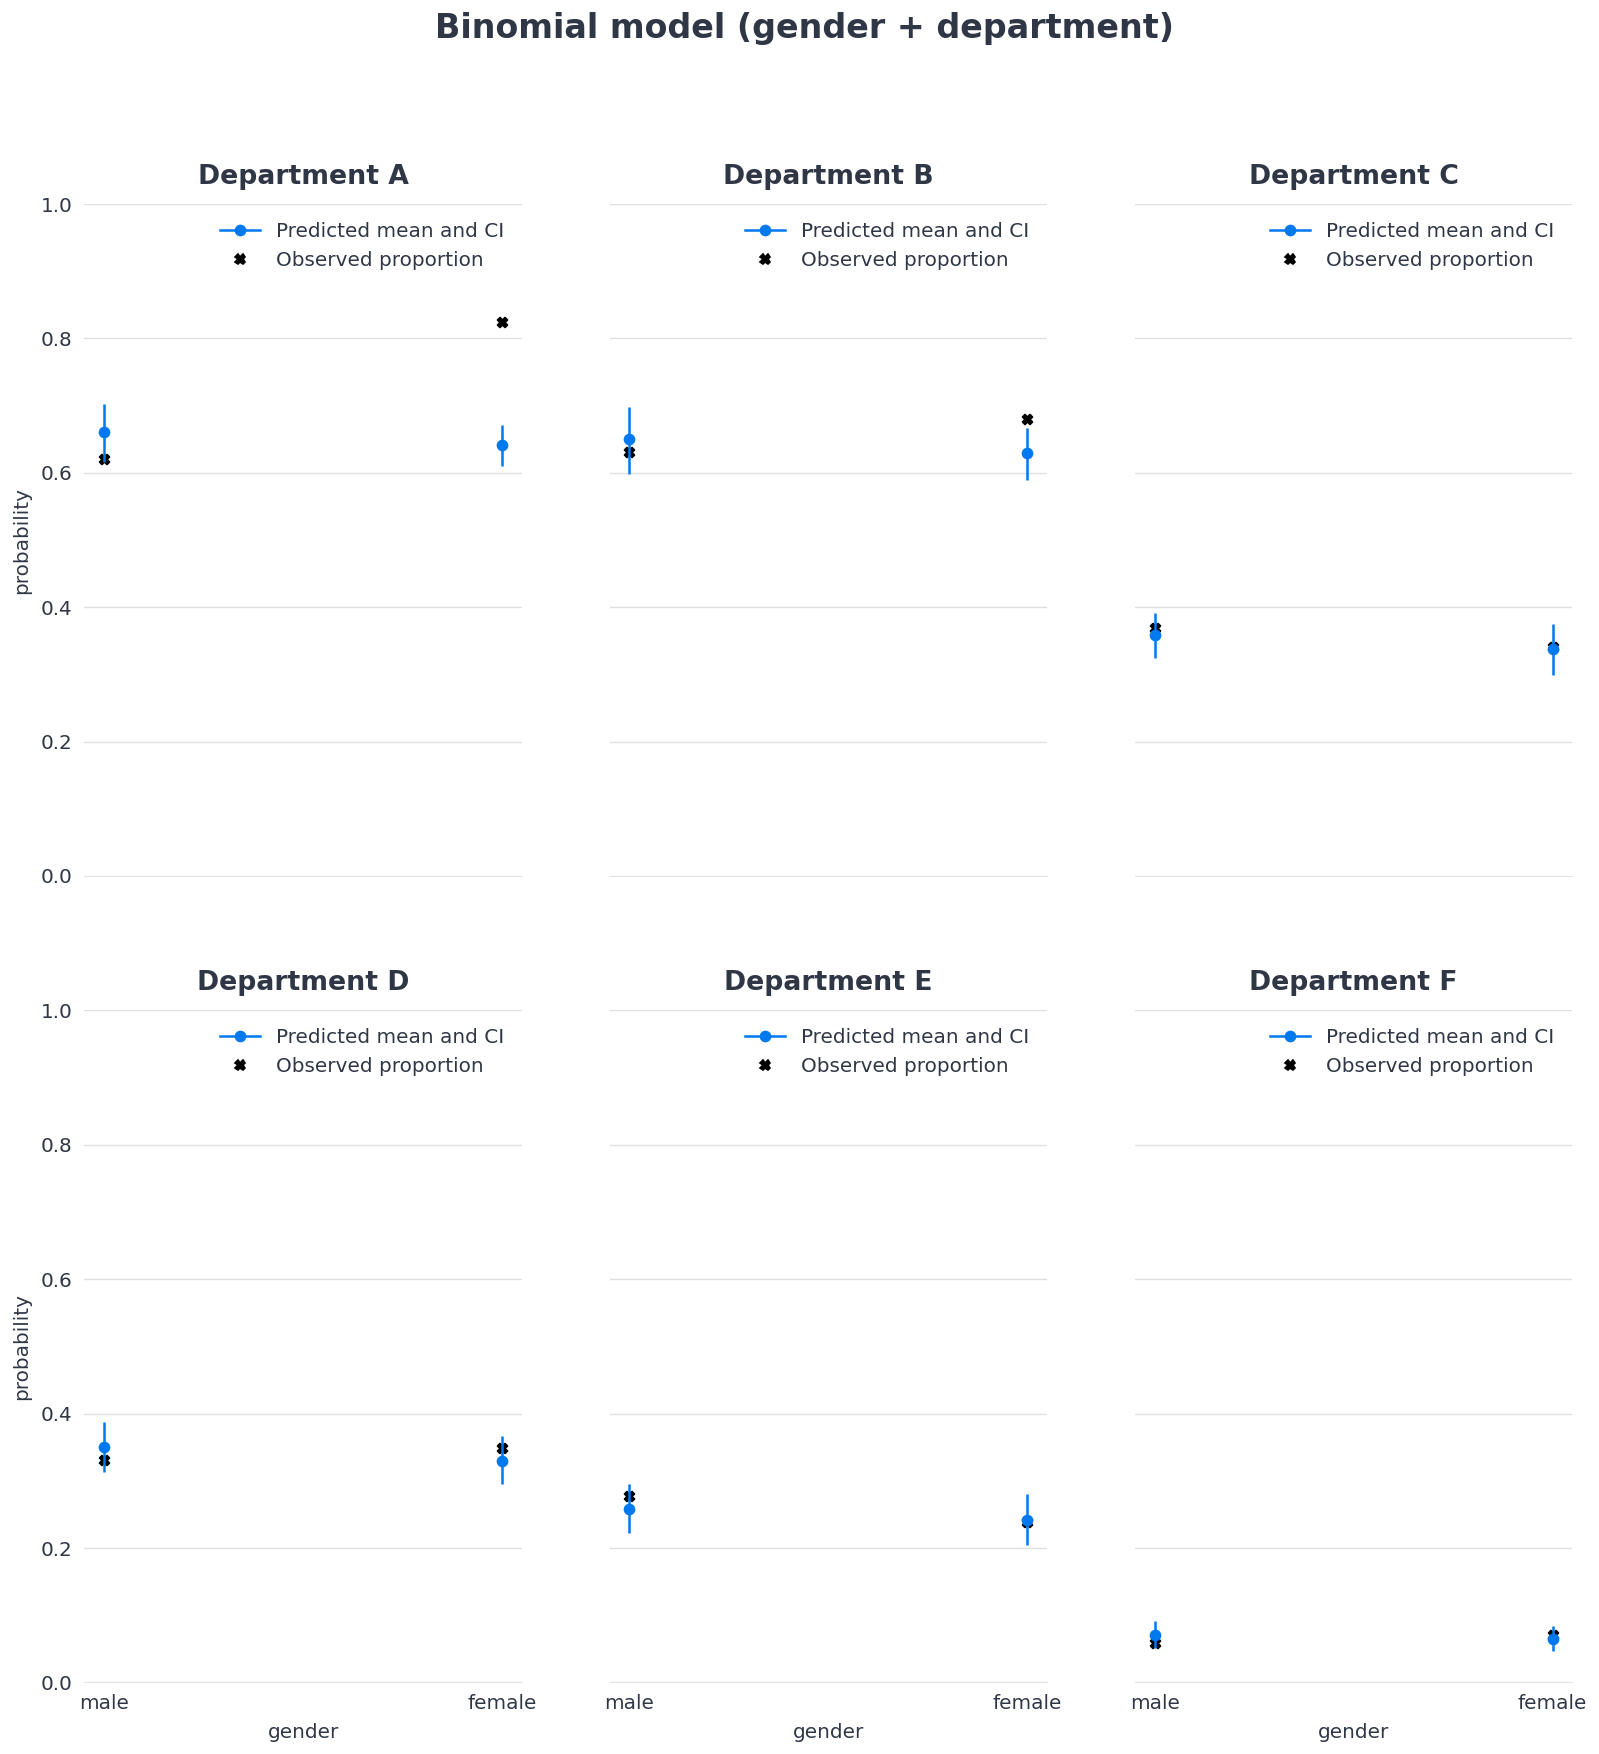

In [32]:
fig, axes = plt.subplots(figsize=(16, 16), nrows=2, ncols=3,  sharex=True, sharey=True)
for i, ((dept_name, dept_df), ax) in enumerate(zip(df_berkely.groupby("dept", observed=False)[["gender", "p"]], axes.ravel())):
    ax.scatter(x="gender", y="p", data=dept_df, marker="X", c="k", label="observed")
    ax.scatter(x=gender, y=p_mean2[i*2: i*2+2], label="predicted")
    ax.vlines(x=gender, ymin=p_qs2[0, i*2: i*2+2], ymax=p_qs2[1, i*2: i*2+2], label="prediction")
    if i == 0:
        ax.set(title=f"Department {dept_name}", ylabel="probability", ylim=(0, 1))
    elif i == 3:
        ax.set(title=f"Department {dept_name}", xlabel="gender", ylabel="probability", ylim=(0, 1))
    elif i > 3:
        ax.set(title=f"Department {dept_name}", xlabel="gender")
    else:
        ax.set(title=f"Department {dept_name}")
    handles = [
    Line2D([], [], color="C0", marker="o", label="Predicted mean and CI"),
    Line2D([], [], color="black", lw=0, marker="X", label="Observed proportion")
    ]
    ax.legend(handles=handles);
fig.suptitle("Binomial model (gender + department)", fontsize=20);

### Check Overdispersion

In [33]:
admits

array([512,  89, 353,  17, 120, 202, 138, 131,  53,  94,  22,  24])

In [34]:
admissions_hdi = (
    az.hdi(admission_naive_idata.posterior_predictive, hdi_prob=0.95)["admissions"].to_numpy()
)

admissions_hdi2 = (
    az.hdi(admission_idata.posterior_predictive, hdi_prob=0.95)["admissions"].to_numpy()
)

In [35]:
post_coverage1 = ((admits >= admissions_hdi[:, 0]) & (admits <= admissions_hdi[:, 1])).mean()
print(f"Posterior predictive coverage: {post_coverage1:.3f}\nOverdispersion = {post_coverage1 < 0.95}")

post_coverage2 = ((admits >= admissions_hdi2[:, 0]) & (admits <= admissions_hdi2[:, 1])).mean()
print(f"Posterior predictive coverage: {post_coverage2:.3f}\nOverdispersion = {post_coverage2 < 0.95}")

Posterior predictive coverage: 0.167
Overdispersion = True
Posterior predictive coverage: 0.917
Overdispersion = True


In [36]:
overdispersed_df = pd.DataFrame({
    "Model": ["Binomial (Gender)", "Binomial (Gender + Dept)"],
    "Coverage": [post_coverage1, post_coverage2],
})

In [37]:
overdispersed_df.assign(Overdispersion= lambda df: df["Coverage"] < 0.95)

,Model,Coverage,Overdispersion
0,Binomial (Gender),0.166667,True
1,Binomial (Gender + Dept),0.916667,True


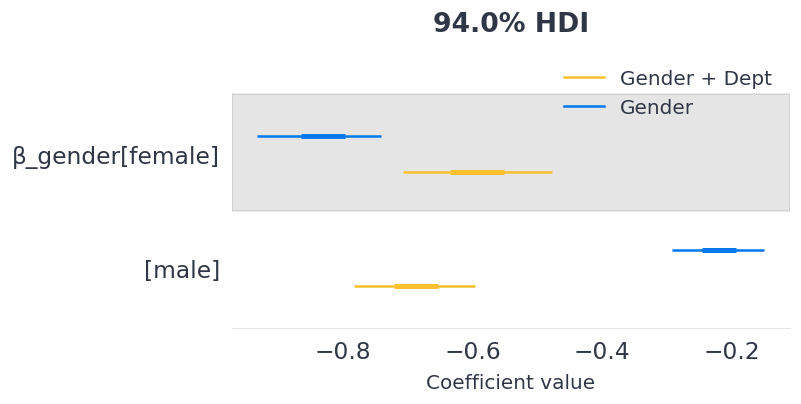

In [38]:
fig, ax = plt.subplots(figsize=(6, 3))

az.plot_forest(
    [admission_naive_idata, admission_idata], 
    model_names=["Gender", "Gender + Dept"],
    var_names="β_gender", 
    combined=True,
    ax=ax
)
ax.set(xlabel="Coefficient value")
plt.show()

### Discussion
Adding a deprtment offset made the coverage improved substantially
* Given the few data points, it's expected for both values not to match perfectly.
* The values we observed could have been the result of the data generating process implied in our second model
* The overdispersion is probably due to **omitted variable bias**
    * the first model was too "simple"
* The second model suggests that both genders are (approximiately) equally likely to be admitted (overlap HDIs), \
as opposed to the first model, which suggests that males have higher chance to be admitted than females
    * the first model suggests that **there is an effect** of type of gender on admission
    * the second model suggests that **there is no significant difference** between the type of gender on admission 

## Poisson vs negative binomial predictive distributions
* fish species diversity dataset.
* model the association between the size of a lake and the number of species in it 
* get the predictive distribution of the number of species in a lake of 1000 squared meters

In [39]:
df_lake = pd.read_csv("../data/lakes.csv")
df_lake["log_lake_area"] = np.log(df_lake["lake_area"])
df_lake

,fish,lake_area,log_lake_area
0,10,5,1.609438
1,37,41,3.713572
2,60,171,5.141664
3,113,25719,10.154985
4,99,59596,10.995344
...,...,...,...
65,5,8,2.079442
66,40,8264,9.019664
67,18,9065,9.112176
68,20,357,5.877736


In [40]:
df_lake["fish"].describe()

count     70.000000
mean      41.742857
std       47.849609
min        5.000000
25%       14.000000
50%       21.500000
75%       47.500000
max      245.000000
Name: fish, dtype: float64

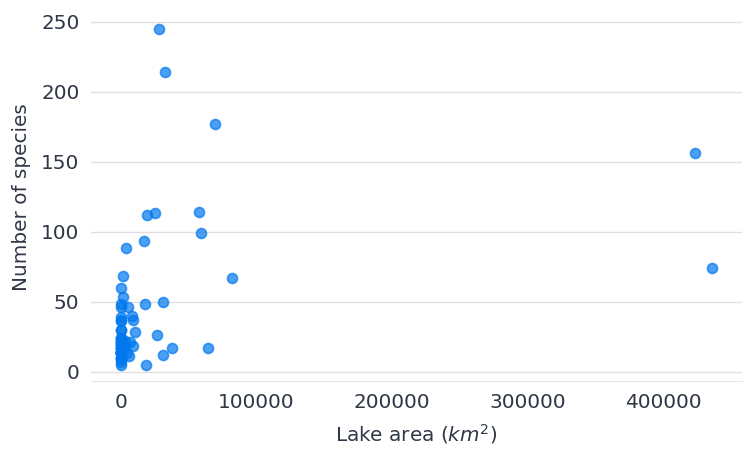

In [41]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.scatter(df_lake["lake_area"], df_lake["fish"], alpha=0.7)
ax.set(xlabel="Lake area ($km^2$)", ylabel="Number of species")
plt.show()

## PyMC
* `coords_mutable` - values in 'obs_idx' will be updated
    * set data and coords for out-of-sample prediction

### Poisson Model

In [45]:
# in-sample observation index ('obs_idx' will be updated in out-sample prediction)
coords = {"obs_idx": np.arange(len(df_lake))}
# coords_mutable - values in 'obs_idx' will be updated
with pm.Model(coords_mutable=coords) as poisson_model:
    # data container
    log_lake_area = (
        pm.MutableData("log_lake_area", df_lake["log_lake_area"].to_numpy(), dims="obs_idx")
    )
    # prior
    intercept = pm.Normal("intercept", 0, 1)  # np.log(mean_fish), np.log(sd_fish)
    β_lake = pm.Normal("β_lake")
    # linear regression
    η = intercept + β_lake * log_lake_area
    λ = pm.Deterministic("λ", pm.math.exp(η))
    # Poisson likelihood
    pm.Poisson("fish", mu=λ, observed=df_lake["fish"].to_numpy(), dims="obs_idx")

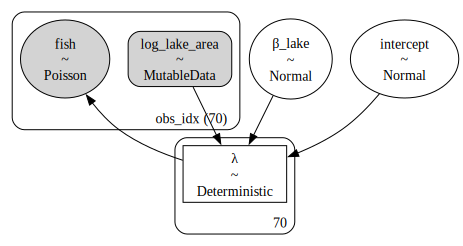

In [46]:
pm.model_to_graphviz(poisson_model)

In [47]:
with poisson_model:
    poisson_idata = pm.sample(chains=4, random_seed=1234)
    poisson_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(poisson_idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, β_lake]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [fish, intercept, β_lake]
Sampling: [fish]


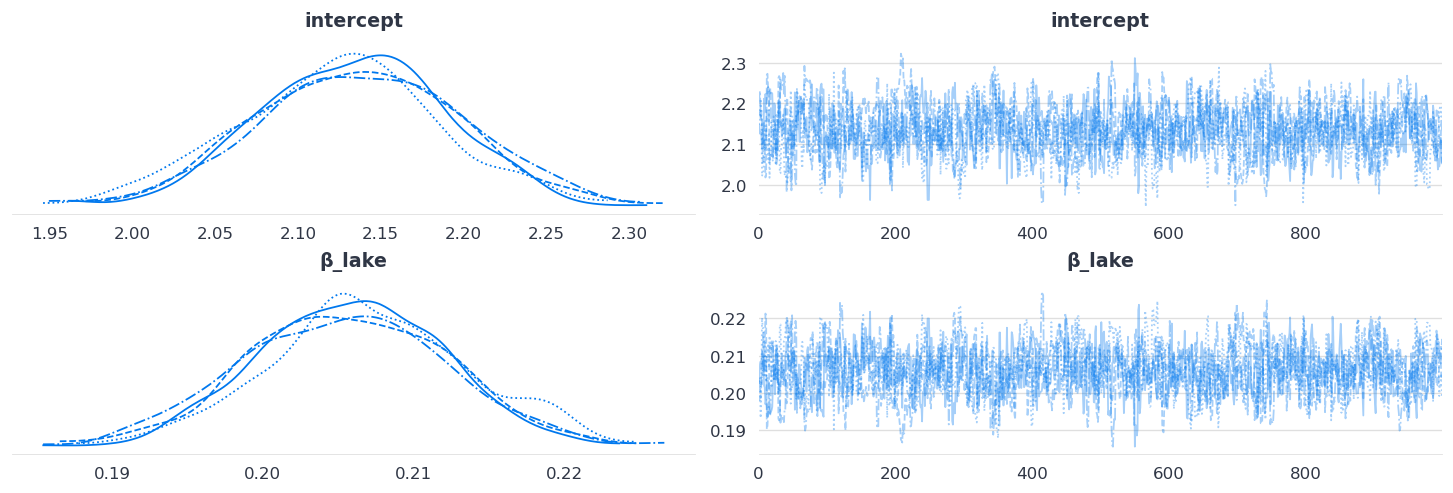

In [48]:
az.plot_trace(poisson_idata, var_names=["intercept", "β_lake"], backend_kwargs={"layout": "constrained"});

In [49]:
az.summary(poisson_idata, var_names=["intercept", "β_lake"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,2.133,0.060,2.022,2.244,0.002,0.002,757.0,1026.0,1.01
β_lake,0.206,0.007,0.194,0.219,0.000,0.000,724.0,1104.0,1.01


#### Predictive Distribution

In [50]:
test_log_lake_area = np.asarray([np.log(1_000)])
test_log_lake_area

array([6.90775528])

In [51]:
with poisson_model:
    pm.set_data(
        new_data={"log_lake_area": test_log_lake_area},  # test values
        coords={"obs_idx": np.array([len(df_lake) + 1])}  # set out-of-sample (new) indexes
    )
    
    pred_poisson_idata = pm.sample_posterior_predictive(
        poisson_idata,
        predictions=True,
        random_seed=1234
    )

Sampling: [fish]


In [52]:
# az.hdi(admission_naive_idata.posterior_predictive, hdi_prob=0.95)["admissions"].to_numpy()
pred_pois_hdi = az.hdi(pred_poisson_idata.predictions, hdi_prob=0.95)["fish"].to_numpy()
pred_pois_hdi

array([[23., 46.]])

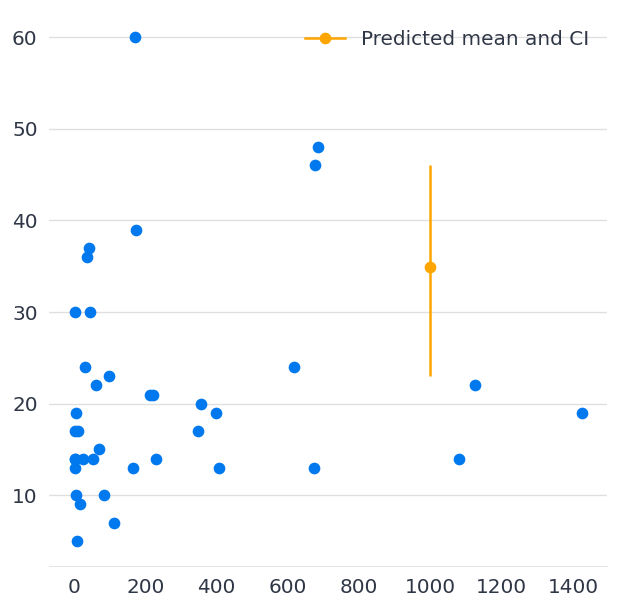

In [53]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=df_lake.query("(lake_area < 2_000)")["lake_area"], y=df_lake.query("(lake_area < 2_000)")["fish"])
ax.scatter(x=1_000, y=pred_poisson_idata.predictions["fish"].mean().item(), color="orange", label="prediction")
ax.vlines(x=1_000, ymin=pred_pois_hdi[0, 0], ymax=pred_pois_hdi[0, 1], label="predicted", color="orange")
handles = [
    Line2D([], [], color="orange", marker="o", label="Predicted mean and CI"),
#     Line2D([], [], color="black", lw=0, marker="X", label="Observed proportion")
    ]
ax.legend(handles=handles)
plt.show()

### Negative Binomial

#### Overdispersion $\phi$ Prior

In [54]:
def get_overdispersion_prior(μ: float, σ_squared: float, init_val: float, optimizer_method: str='L-BFGS-B') -> float:
    """overdispersion estimate for NB likelihood"""
    def mae_loss(ϕ: float, μ: float, σ_squared: float) -> float:
        pred = μ + (μ ** 2) * ϕ
        return np.abs(σ_squared - pred)
    fun = partial(mae_loss, μ=μ, σ_squared=σ_squared)
    bounds = [(0, np.inf)]  # positive value
    opt_res = minimize(fun, init_val, bounds=bounds, method=optimizer_method)
    ϕ_star = opt_res.x[0]  # overdispersion parameter
    loss = opt_res.fun
    return ϕ_star, loss

In [55]:
ϕ, loss = get_overdispersion_prior(df_lake["fish"].mean(), df_lake["fish"].var(), init_val=0.5)

In [56]:
ϕ, 1/ϕ  #  1/ϕ <-> α

(1.2900349703500453, 0.7751727844468079)

In [57]:
MASS = 0.95
LOWER = 1 / ϕ - 0.8
UPPER = 1 / ϕ + 0.8
constrained_priors = pm.find_constrained_prior(
    distribution=pm.InverseGamma,
    lower=LOWER,
    upper=UPPER,
    mass=MASS,
    init_guess=dict(alpha=4, beta=4))

In [58]:
constrained_priors

{'alpha': 5.0421670284243785, 'beta': 3.1449283336718503}

<Axes: >

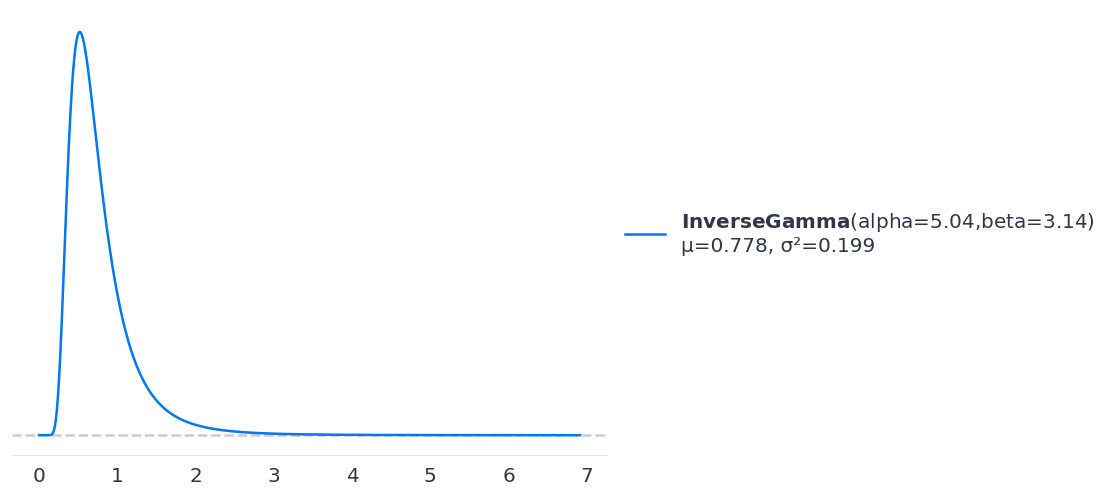

In [59]:
pz.InverseGamma(**constrained_priors).plot_pdf(moments=["m", "v"])

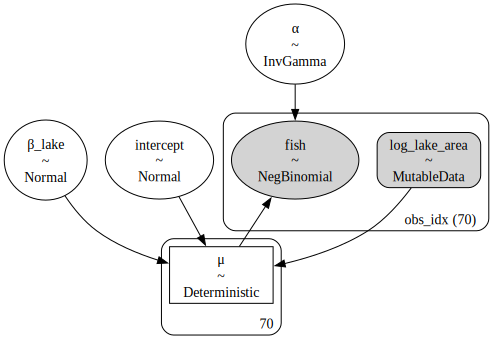

In [74]:
# in-sample observation index ('obs_idx' will be updated in out-sample prediction)
coords = {"obs_idx": np.arange(len(df_lake))}
# coords_mutable - values in 'obs_idx' will be updated
with pm.Model(coords_mutable=coords) as nb_model:
    # data container
    log_lake_area = (
        pm.MutableData("log_lake_area", df_lake["log_lake_area"].to_numpy(), dims="obs_idx")
    )
    # prior
    intercept = pm.Normal("intercept", 0, 5)  # np.log(mean_fish), np.log(sd_fish)
    β_lake = pm.Normal("β_lake")
    # linear regression
    η = intercept + β_lake * log_lake_area
    μ = pm.Deterministic("μ", pm.math.exp(η))
    # α = pm.InverseGamma("α", alpha=4, beta=2)  # **constrained_priors)
    α = pm.InverseGamma("α", **constrained_priors)
    # Negative Binomial likelihood
    pm.NegativeBinomial("fish", mu=μ, alpha=α, observed=df_lake["fish"].to_numpy(), dims="obs_idx")
    
pm.model_to_graphviz(nb_model)

In [75]:
with nb_model:
    nb_idata = pm.sample(chains=4, random_seed=1111)
    nb_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(nb_idata, random_seed=1234, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, β_lake, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Sampling: [fish, intercept, α, β_lake]
Sampling: [fish]


In [76]:
nb_idata.posterior["overdispersion"] = 1 / nb_idata.posterior["α"]

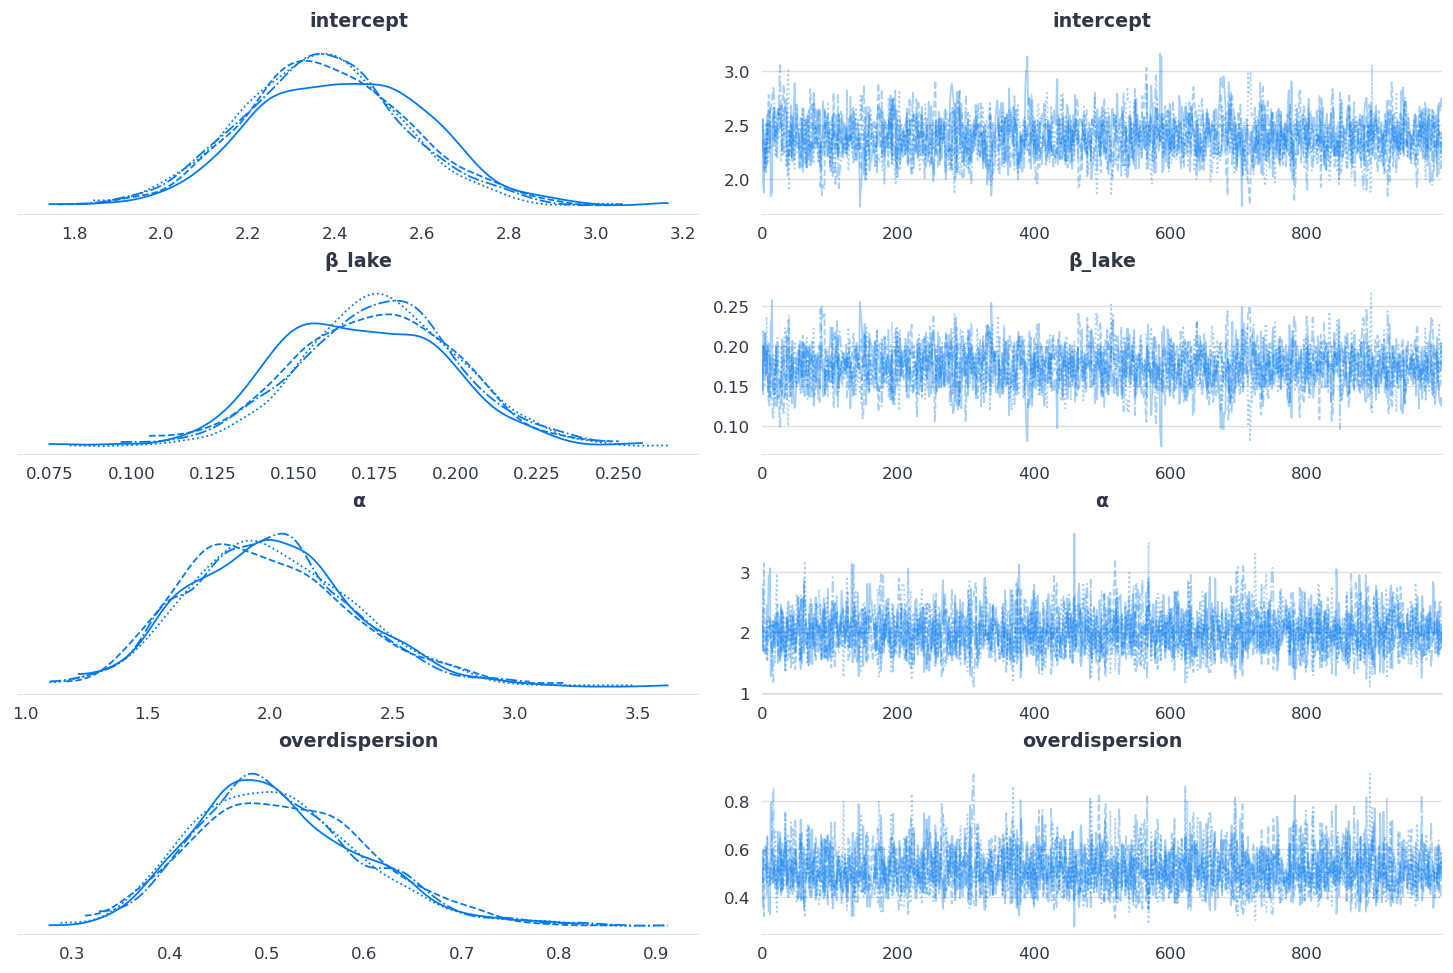

In [77]:
az.plot_trace(
    nb_idata,
    var_names=["intercept", "β_lake", "α", "overdispersion"],
    backend_kwargs={"layout": "constrained"}
);

In [78]:
az.summary(nb_idata, var_names=["intercept", "β_lake", "α", "overdispersion"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,2.384,0.193,2.034,2.755,0.005,0.004,1412.0,1663.0,1.01
β_lake,0.175,0.025,0.130,0.224,0.001,0.000,1393.0,1640.0,1.01
α,2.000,0.341,1.404,2.663,0.007,0.005,2630.0,2499.0,1.00
overdispersion,0.515,0.089,0.355,0.674,0.002,0.001,2630.0,2499.0,1.00


#### Predictive Distribution

In [79]:
with nb_model:
    pm.set_data(
        new_data={"log_lake_area": test_log_lake_area},  # test values
        coords={"obs_idx": np.array([len(df_lake) + 1])}  # set out-of-sample (new) indexes
    )
    
    pred_nb_idata = pm.sample_posterior_predictive(
        nb_idata,
        predictions=True,
        random_seed=1234
    )

Sampling: [fish]


In [80]:
pred_nb_hdi = az.hdi(pred_nb_idata.predictions, hdi_prob=0.95)["fish"].to_numpy()
pred_nb_hdi

array([[ 0., 89.]])

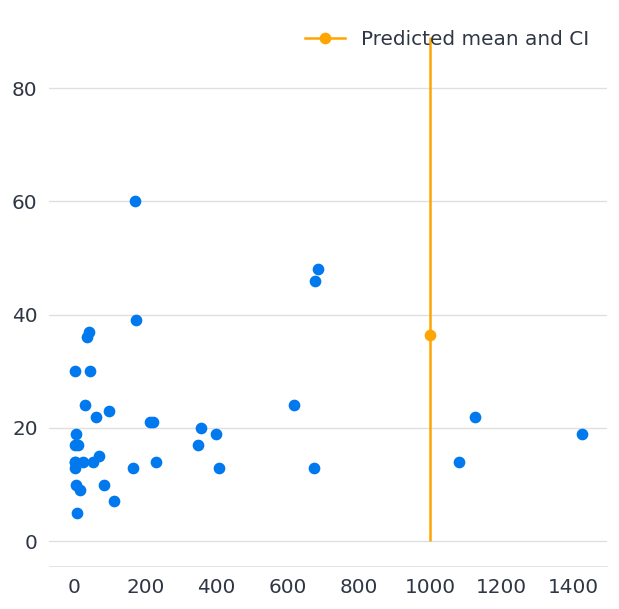

In [81]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=df_lake.query("(lake_area < 2_000)")["lake_area"], y=df_lake.query("(lake_area < 2_000)")["fish"])
ax.scatter(x=1_000, y=pred_nb_idata.predictions["fish"].mean().item(), color="orange", label="prediction")
ax.vlines(x=1_000, ymin=pred_nb_hdi[0, 0], ymax=pred_nb_hdi[0, 1], label="predicted", color="orange")
handles = [
    Line2D([], [], color="orange", marker="o", label="Predicted mean and CI"),
#     Line2D([], [], color="black", lw=0, marker="X", label="Observed proportion")
    ]
ax.legend(handles=handles);

In [82]:
pois_preds = pred_poisson_idata.predictions.sel(obs_idx=len(df_lake)+1)["fish"].to_numpy().flatten()
nb_preds = pred_nb_idata.predictions.sel(obs_idx=len(df_lake)+1)["fish"].to_numpy().flatten()

In [83]:
print(f"Poisson predicted mean = {pois_preds.mean()}, predicted var = {pois_preds.var()}")
print(f"NB predicted mean = {nb_preds.mean()}, predicted var = {nb_preds.var()}")

Poisson predicted mean = 34.92375, predicted var = 35.2729359375
NB predicted mean = 36.463, predicted var = 717.1516310000001


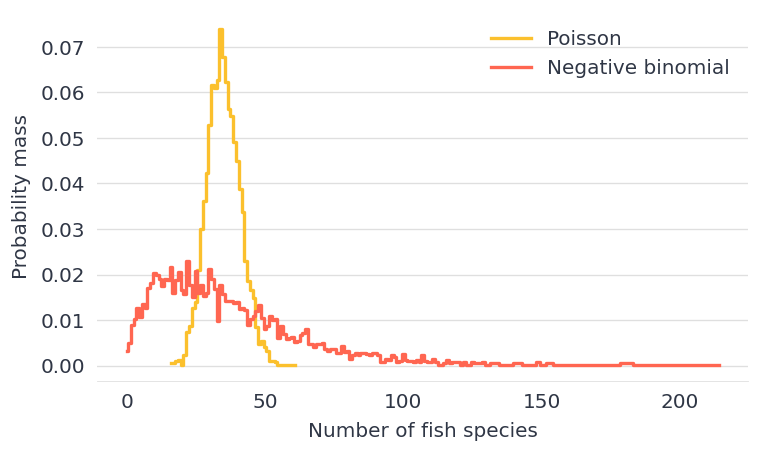

In [84]:
fig, ax = plt.subplots(figsize=FIGSIZE)

# Get the values of 'x' and 'y' for both cases
x_poisson, counts_poisson = np.unique(pois_preds, return_counts=True)
x_nb, counts_nb = np.unique(nb_preds, return_counts=True)

# Plot the distributions using a step function.
ax.step(x_poisson, counts_poisson / counts_poisson.sum(), color="C1", where="mid", linewidth=2, label="Poisson")
ax.step(x_nb, counts_nb / counts_nb.sum(), color="C4", where="mid", linewidth=2, label="Negative binomial")
ax.legend()

ax.set(xlabel="Number of fish species", ylabel="Probability mass");

## Bambi

### Poisson

In [85]:
pois_priors = {
    "Intercept": bmb.Prior("Normal", mu=2, sigma=1),
    "log_lake_area": bmb.Prior("Normal", mu=0, sigma=1)
}
pois_bmb_model = bmb.Model("fish ~ 1 + log_lake_area", data=df_lake, priors=pois_priors, family="poisson")
pois_bmb_idata = pois_bmb_model.fit(chains=4, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Intercept, log_lake_area]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [86]:
test_df = pd.DataFrame({"log_lake_area": test_log_lake_area})

In [87]:
bmb_pois_preds_idata = pois_bmb_model.predict(pois_bmb_idata, data=test_df, kind="pps", inplace=False)

### Negative Binomial

In [88]:
nb_priors = {
    "Intercept": bmb.Prior("Normal", mu=2, sigma=1), 
    "log_lake_area": bmb.Prior("Normal", mu=0, sigma=1),
    "alpha": bmb.Prior("InverseGamma", **constrained_priors)
}
nb_bmb_model = bmb.Model("fish ~ 1 + log_lake_area", data=df_lake, priors=nb_priors, family="negativebinomial")
nb_bmb_idata = nb_bmb_model.fit(chains=4, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [fish_alpha, Intercept, log_lake_area]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [89]:
bmb_nb_preds_idata = nb_bmb_model.predict(nb_bmb_idata, data=test_df, kind="pps", inplace=False)

In [90]:
bmb_pois_preds = bmb_pois_preds_idata.posterior_predictive.sel(fish_obs=0)["fish"].to_numpy().flatten()
bmb_nb_preds = bmb_nb_preds_idata.posterior_predictive.sel(fish_obs=0)["fish"].to_numpy().flatten()

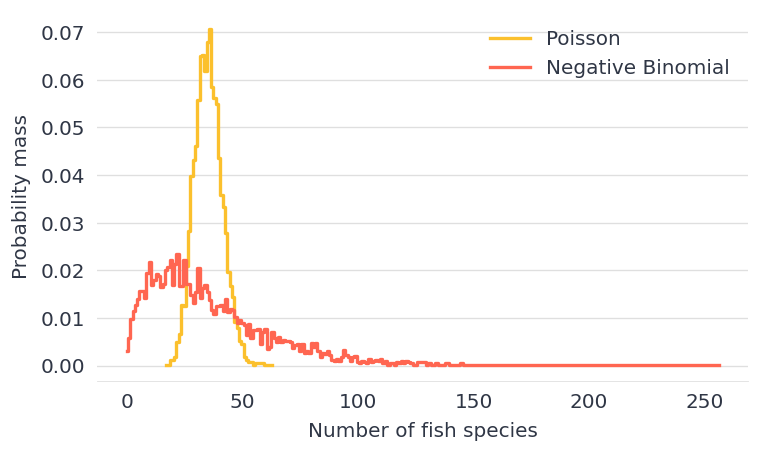

In [91]:
fig, ax = plt.subplots(figsize=FIGSIZE)

# Get the values of 'x' and 'y' for both cases
x_poisson, counts_poisson = np.unique(bmb_pois_preds, return_counts=True)
x_nb, counts_nb = np.unique(bmb_nb_preds, return_counts=True)

# Plot the distributions using a step function.
ax.step(x_poisson, counts_poisson / counts_poisson.sum(), color="C1", where="mid", linewidth=2, label="Poisson")
ax.step(x_nb, counts_nb / counts_nb.sum(), color="C4", where="mid", linewidth=2, label="Negative Binomial")
ax.legend()

ax.set(xlabel="Number of fish species", ylabel="Probability mass");

## Iterpreting the Intercept
* The intercept represents the log of the average species, for a lake of 1 squared kilometers
* if we apply the log transformation after scaling the area by the mean, we get that the intercept\
represents the (log) mean number of species for a lake of average size:\
$\log{\Big ( \frac{y}{\bar{y}} \Big )} = \log{(y}) - \log{(\bar{y}})$
    * $\log{\Big (\frac{x_2}{x_1} \Big )} = \log{(x_2}) - \log{(x_2})$ - **recentering w.r.t. $x_2$ in the log space**
    *  $\log{\Big (\frac{x_2}{x_1} \Big )} \approx \frac{x_2 - x_1}{x_1} = \frac{x_2}{x_1} - 1 $- the log ratio is an approximation of the percent change of $x_2$ w.r.t. $x_1$
    * $\log{(x)} \approx x - 1 $- the first Taylor approximation of $\log{(x)}$ is $x-1$
* $\log{\Big ( \frac{y}{1,000} \Big )}$ will make the intercept relate to the number of species of a lake of 1000 squared kilometers

In [93]:
df_lake = (
    df_lake.assign(
        log_lake_area = lambda df: np.log(df["lake_area"]),
        log_lake_area_recenter_by_mean=lambda df: np.log(df["lake_area"] / df["lake_area"].mean()),
        log_lake_area_recenter_by_1000=lambda df: np.log(df["lake_area"] / 1_000)
    )
)
df_lake.head()

,fish,lake_area,log_lake_area,log_lake_area_recenter_by_mean,log_lake_area_recenter_by_1000
0,10,5,1.609438,-8.408662,-5.298317
1,37,41,3.713572,-6.304528,-3.194183
2,60,171,5.141664,-4.876436,-1.766092
3,113,25719,10.154985,0.136885,3.247230
4,99,59596,10.995344,0.977244,4.087588


In [94]:
# in-sample observation index ('obs_idx' will be updated in out-sample prediction)
lake_coords = {"obs_idx": np.arange(len(df_lake))}

log_lake_area_recenter_by_mean = df_lake["log_lake_area_recenter_by_mean"].to_numpy()
observed_fish = df_lake["fish"].to_numpy()

# coords_mutable - values in 'obs_idx' will be updated
with pm.Model(coords_mutable=lake_coords) as poisson_recenter_by_mean_model:
    # data container
    log_lake_area = (
        pm.MutableData("log_lake_area",log_lake_area_recenter_by_mean , dims="obs_idx")
    )
    # prior
    intercept = pm.Normal("intercept", 0, 5) 
    β_lake = pm.Normal("β_lake")
    # regression model centered w.r.t the lake of average size
    η = intercept + β_lake * log_lake_area
    λ = pm.Deterministic("λ", pm.math.exp(η))
    # likelihood
    pm.Poisson("fish", mu=λ, observed=observed_fish, dims="obs_idx")

In [95]:
log_lake_area_recenter_by_1000 = df_lake["log_lake_area_recenter_by_1000"].to_numpy()

with pm.Model(coords_mutable=lake_coords) as poisson_recenter_by_1000_model:
    # data container
    log_lake_area = (
        pm.MutableData("log_lake_area", log_lake_area_recenter_by_1000, dims="obs_idx")
    )
    # prior
    intercept = pm.Normal("intercept", 0, 5)  # np.log(mean_fish), np.log(sd_fish)
    β_lake = pm.Normal("β_lake")
    # regression model centered w.r.t the lake of 1000 squared kilometers
    η = intercept + β_lake * log_lake_area
    λ = pm.Deterministic("λ", pm.math.exp(η))
    # likelihood
    pm.Poisson("fish", mu=λ, observed=observed_fish, dims="obs_idx")

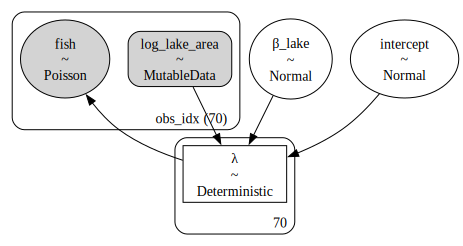

In [96]:
pm.model_to_graphviz(poisson_recenter_by_mean_model)

In [97]:
with poisson_recenter_by_mean_model:
    poisson_recenter_by_mean_idata = pm.sample(chains=4, random_seed=1234)
    poisson_recenter_by_mean_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(poisson_recenter_by_mean_idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, β_lake]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [fish, intercept, β_lake]
Sampling: [fish]


In [98]:
with poisson_recenter_by_1000_model:
    poisson_recenter_by_1000_idata = pm.sample(chains=4, random_seed=1234)
    poisson_recenter_by_1000_idata.extend(pm.sample_prior_predictive())
    pm.sample_posterior_predictive(poisson_recenter_by_1000_idata, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, β_lake]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: [fish, intercept, β_lake]
Sampling: [fish]


In [99]:
az.summary(poisson_recenter_by_mean_idata, var_names=["~λ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,4.197,0.020,4.159,4.235,0.0,0.0,2772.0,2355.0,1.0
β_lake,0.205,0.007,0.193,0.219,0.0,0.0,2982.0,2317.0,1.0


In [101]:
print((
    'mean number of species for a lake of average size: ' 
    f'{np.exp(poisson_recenter_by_mean_idata.posterior["intercept"]).mean().item():.3f}'))


mean number of species for a lake of average size: 66.475


In [102]:
az.summary(poisson_recenter_by_1000_idata, var_names=["~λ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,3.558,0.022,3.515,3.597,0.0,0.0,2255.0,2599.0,1.0
β_lake,0.205,0.007,0.193,0.218,0.0,0.0,1978.0,2107.0,1.0


In [103]:
print((
    'mean number of species for a lake of 1000 squared kilometers: ' 
    f'{np.exp(poisson_recenter_by_1000_idata.posterior["intercept"]).mean().item():.3f}'))


mean number of species for a lake of 1000 squared kilometers: 35.095


### Predictions
* predict average #(fish) for a lake of average size given model recenered w.r.t lake of 1000 squared kilometers
    * same as the intercept of the model centered w.r.t. the lake of average size
* predict average #(fish) for a lake of 1000 squared kilometers given model recenered w.r.t a lake of average size
    * same as the intercept of the model centered w.r.t. the lake of 1000 squared kilometers

In [104]:
test_lake_df = pd.DataFrame(
    {'lake_area': [df_lake["lake_area"].mean(), 1_000] },
    index=np.arange(len(df_lake), len(df_lake) + 2))
test_lake_df = test_lake_df.assign(
    log_lake_area = lambda df: np.log(df["lake_area"]),
    log_lake_area_recenter_by_mean=lambda df: np.log(df["lake_area"] / df_lake["lake_area"].mean()),
    log_lake_area_recenter_by_1000=lambda df: np.log(df["lake_area"] / 1_000)
)
test_lake_df

,lake_area,log_lake_area,log_lake_area_recenter_by_mean,log_lake_area_recenter_by_1000
70,22428.771429,10.018100,0.000000,3.110345
71,1000.000000,6.907755,-3.110345,0.000000


In [105]:
with poisson_recenter_by_mean_model:
    pm.set_data(
        new_data={"log_lake_area": test_lake_df['log_lake_area_recenter_by_mean'].to_numpy()},  # test values
        coords={"obs_idx": test_lake_df.index}  # set out-of-sample (new) indexes
    )
    
    pred_poisson_recenter_by_mean_idata = pm.sample_posterior_predictive(
        poisson_recenter_by_mean_idata,
        predictions=True,
        random_seed=1234
    )

Sampling: [fish]


In [106]:
with poisson_recenter_by_1000_model:
    pm.set_data(
        new_data={"log_lake_area": test_lake_df['log_lake_area_recenter_by_1000'].to_numpy()},  # test values
        coords={"obs_idx": test_lake_df.index}  # set out-of-sample (new) indexes
    )
    
    pred_poisson_recenter_by_1000_idata = pm.sample_posterior_predictive(
        poisson_recenter_by_1000_idata,
        predictions=True,
        random_seed=1234
    )

Sampling: [fish]


In [107]:
# 1_000
pred_1000 = pred_poisson_recenter_by_mean_idata.predictions.sel(obs_idx=71)["fish"].mean().item()
print((
    "mean model prediction for 1,000 squared Kilometers:\n"
    f"prediction: {pred_1000:10.3f}\nlog(prediction): {np.log(pred_1000):.3f}"))

mean model prediction for 1,000 squared Kilometers:
prediction:     35.063
log(prediction): 3.557


In [108]:
# mean
pred_mean = pred_poisson_recenter_by_1000_idata.predictions.sel(obs_idx=70)["fish"].mean().item()
print((
    "1,000 model prediction for a lake of average size:\n"
    f"prediction: {pred_mean:10.3f}\nlog(prediction): {np.log(pred_mean):.3f}"))

1,000 model prediction for a lake of average size:
prediction:     66.255
log(prediction): 4.194


# Survival rate of trout eggs
* predict survival rate for 5 different locations (1, 2, 3, 4, 5) and 4 time periods  (4, 7, 8, 11)
* models- Binomial likelihood vs BetaBinomial likelihood


In [4]:
df_troutegg = pd.read_csv("../data/trout_egg.csv")  # , dtype={"location": "category", "period": "category"})
print(df_troutegg.shape)
df_troutegg.head()

(20, 4)


,survive,total,location,period
0,89,94,1,4
1,106,108,2,4
2,119,123,3,4
3,104,104,4,4
4,49,93,5,4


In [5]:
df_troutegg = df_troutegg.assign(p_observed=lambda df: df["survive"] / df["total"])
df_troutegg.head()

,survive,total,location,period,p_observed
0,89,94,1,4,0.946809
1,106,108,2,4,0.981481
2,119,123,3,4,0.967480
3,104,104,4,4,1.000000
4,49,93,5,4,0.526882


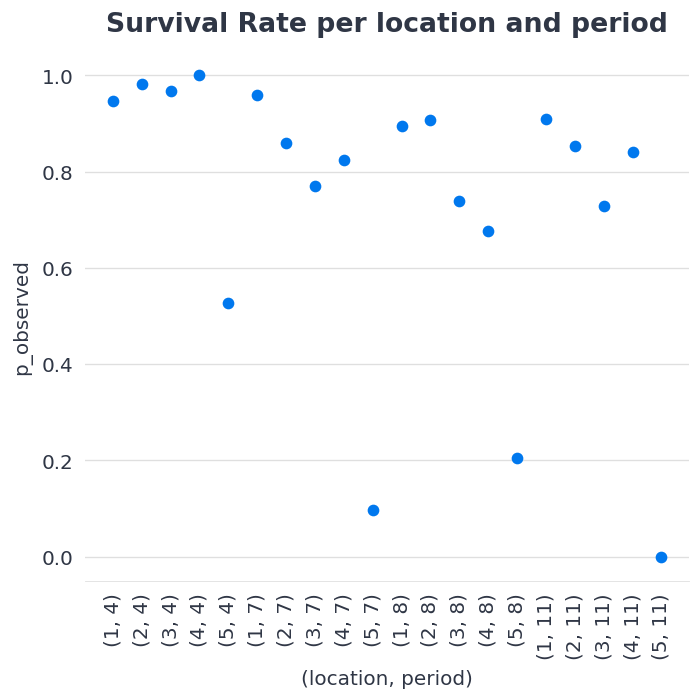

In [6]:
fig, ax = plt.subplots(figsize=(6, 6), layout="tight")
ax.scatter(
    x=(
        df_troutegg[["location", "period"]]
        .apply(lambda row: f'({row["location"]}, {row["period"]})', axis=1)),
    y=df_troutegg["p_observed"])
ax.tick_params(axis="x", rotation=90);
ax.set(xlabel="(location, period)", ylabel="p_observed", title="Survival Rate per location and period")
plt.show()

<Axes: xlabel='period'>

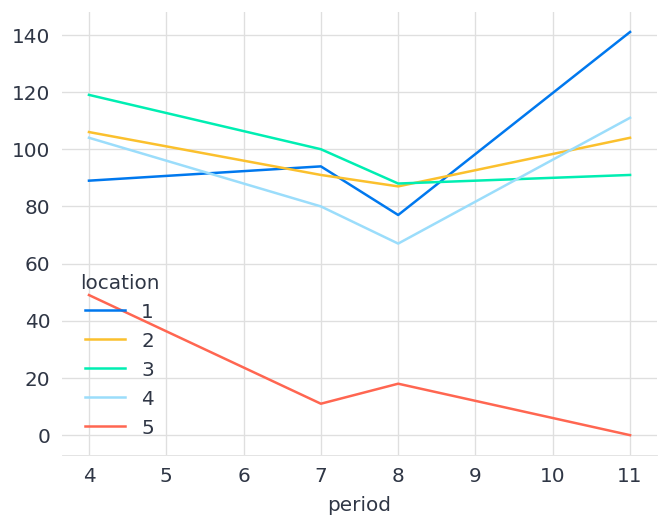

In [7]:
pd.pivot(index="location", columns="period", values="survive", data=df_troutegg).T.plot()

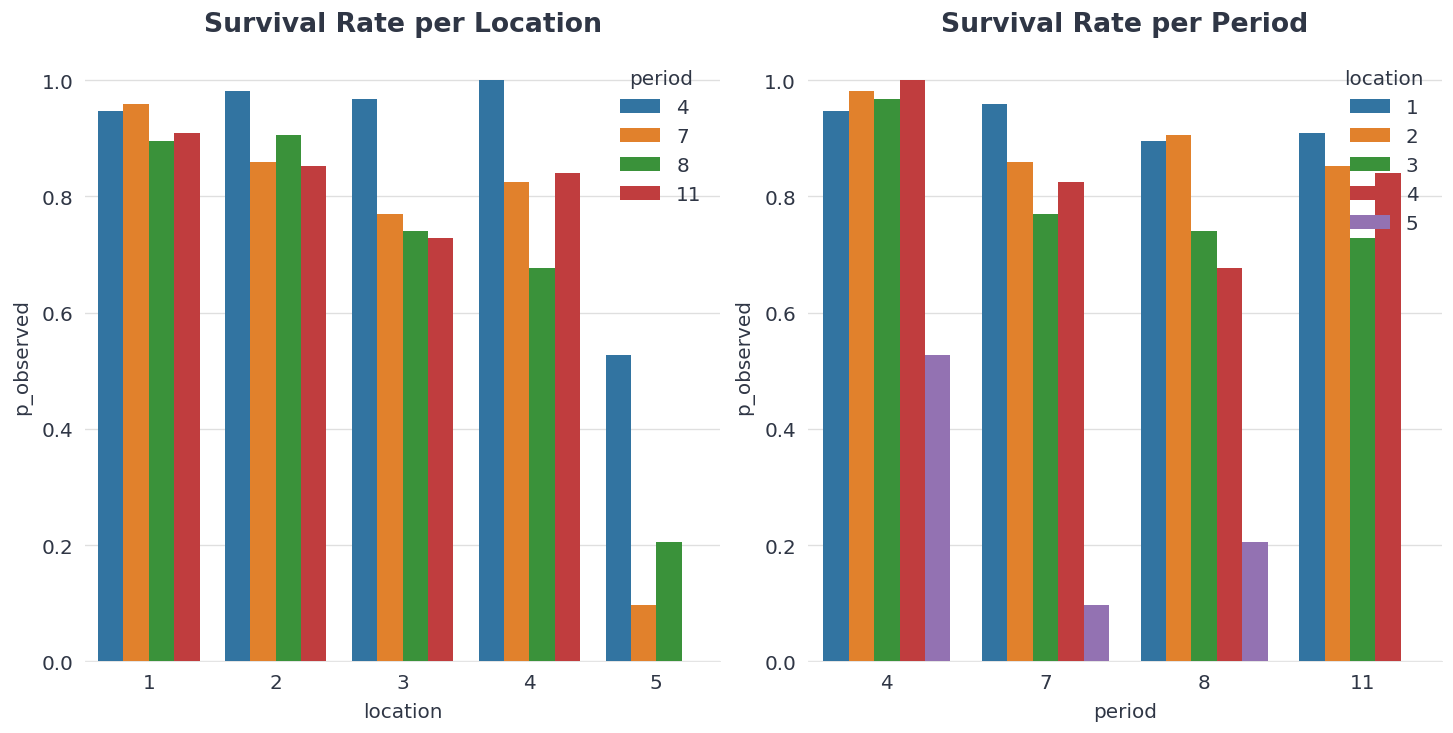

In [8]:
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2, layout="constrained")
sns.barplot(x="location", y="p_observed", hue="period", data=df_troutegg, palette="tab10", ax=axes[0])
sns.barplot(x="period", y="p_observed", hue="location", data=df_troutegg, palette="tab10", ax=axes[1])
axes[0].set(title="Survival Rate per Location")
axes[1].set(title="Survival Rate per Period")
plt.show()

## Models
1. Binomial Additive- intercept + location and period
    * 20 examples, 4 + 5 offsets
1. Binomial Interaction- interaction between location with no intercept
    * 20 examples, 4*5 offsets
1. BetaBinomial Additive-
    * 20 examples, 4 + 5 offsets
1. BetaBinomial Interaction
    * 20 examples, 4*5 offsets

In [9]:
bin_priors = {
    "location": bmb.Prior("Normal", mu=0, sigma=1),
    "period": bmb.Prior("Normal", mu=0, sigma=1)
}

additive_bin_model = bmb.Model(
    # proportion of survived eggs out of total eggs
    formula="p(survive, total) ~ 1 + location + period ",
    data=df_troutegg,
    priors=bin_priors,
    family="binomial",
    categorical=["location", "period"]
)

interaction_bin_model = bmb.Model(
    formula="p(survive, total) ~ 0 + location:period ",
    data=df_troutegg,
    priors=bin_priors,
    family="binomial",
    categorical=["location", "period"]
)

beta_bin_priors = {
    "location": bmb.Prior("Normal", mu=0, sigma=1),
    "period": bmb.Prior("Normal", mu=0, sigma=1), 
    "kappa": bmb.Prior("Gamma", alpha=5, beta=0.25)
}

additive_beta_bin_model = bmb.Model(
    formula="p(survive, total) ~ 1 + location + period ",
    data=df_troutegg,
    priors=beta_bin_priors,
    family="beta_binomial",
    categorical=["location", "period"]
)

interaction_beta_bin_model = bmb.Model(
    formula="p(survive, total) ~ 0 + location:period ",
    data=df_troutegg,
    priors=beta_bin_priors,
    family="beta_binomial",
    categorical=["location", "period"]
)

/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/formulae/terms/variable.py:87: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x):
/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/formulae/terms/variable.py:87: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x):
/home/studio-lab-user/.conda/envs/ib_adv

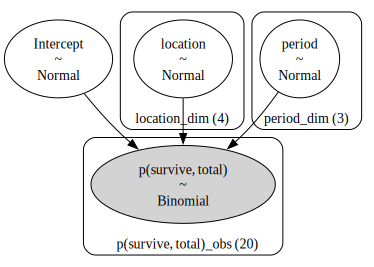

In [10]:
additive_bin_model.build()
additive_bin_model.graph()

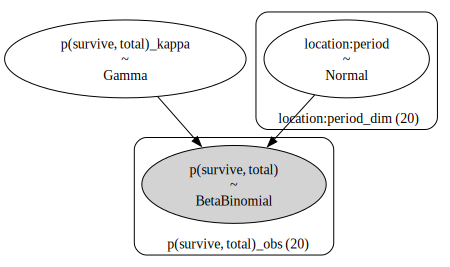

In [11]:
interaction_beta_bin_model.build()
interaction_beta_bin_model.graph()

In [20]:
additive_bin_idata = additive_bin_model.fit(random_seed=1234)
interaction_bin_idata = interaction_bin_model.fit(random_seed=1234)
additive_beta_bin_idata = additive_beta_bin_model.fit(random_seed=1234)
interaction_beta_bin_idata = interaction_beta_bin_model.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, location, period]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [location:period]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p(survive, total)_kappa, Intercept, location, period]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p(survive, total)_kappa, location:period]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Predictions
estimate survival rate on:
* location == 4 and period == 4
* location == 4 and period == 8
* location == 5 and period == 11

In [21]:
# (4, 4), (4, 8), (5, 11)
df_troutegg.query("(location in [4, 5]) and (period in [4, 8, 11])")
test_trout_egg = df_troutegg.iloc[[13, 19, 3],:]
test_trout_egg

,survive,total,location,period,p_observed
13,67,99,4,8,0.676768
19,0,138,5,11,0.000000
3,104,104,4,4,1.000000


In [22]:
pred_additive_bin_idata = additive_bin_model.predict(additive_bin_idata, data=test_trout_egg, kind="pps", inplace=False)
pred_interaction_bin_idata = interaction_bin_model.predict(interaction_bin_idata, data=test_trout_egg, kind="pps", inplace=False)
pred_additive_beta_bin_idata = additive_beta_bin_model.predict(additive_beta_bin_idata, data=test_trout_egg, kind="pps", inplace=False)
pred_interaction_beta_bin_idata = interaction_beta_bin_model.predict(interaction_beta_bin_idata, data=test_trout_egg, kind="pps", inplace=False)

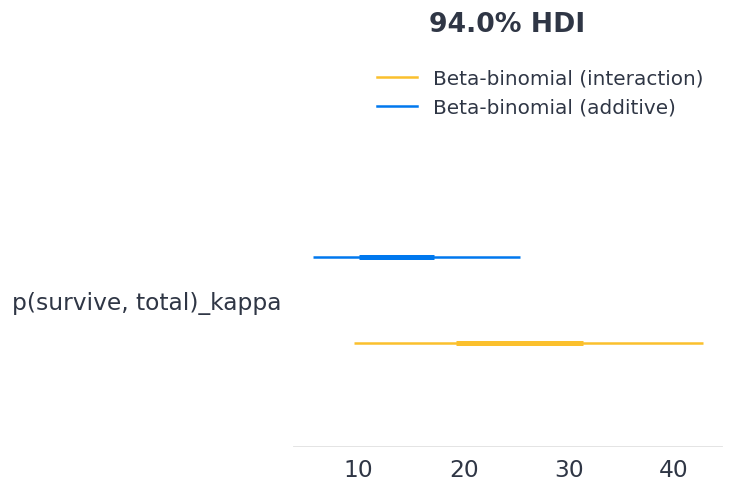

In [23]:
# plot overdispersion- high kappa <-> low variance
az.plot_forest(
    data=[additive_beta_bin_idata, interaction_beta_bin_idata],
    model_names=['Beta-binomial (additive)', 'Beta-binomial (interaction)'], 
    var_names="p(survive, total)_kappa",
    combined=True,
    backend_kwargs={"layout": "constrained"},
    figsize=(6, 4)
)
plt.show()

In [24]:
model_names = ["Binomial (additive)", "Binomial (interaction)", "Beta-Binomial (additive)", "Beta-Binomial (interaction)"]
model_names

['Binomial (additive)',
 'Binomial (interaction)',
 'Beta-Binomial (additive)',
 'Beta-Binomial (interaction)']

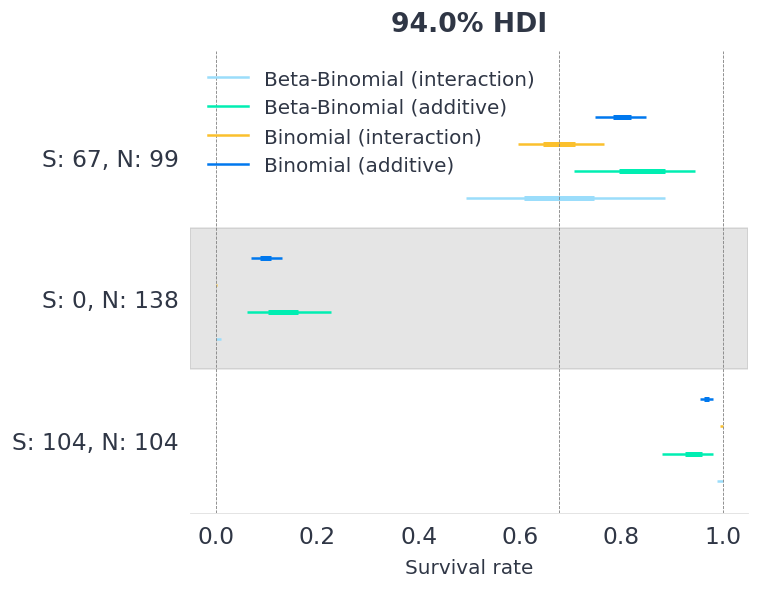

In [36]:
fig, ax = plt.subplots(figsize=(6, 5))

az.plot_forest(
    data=[pred_additive_bin_idata, pred_interaction_bin_idata, pred_additive_beta_bin_idata, pred_interaction_beta_bin_idata],
    model_names=model_names,
    var_names=["p(survive, total)_mean"],
    combined=True,
    ax=ax
)


ylabels = (
    test_trout_egg
    .apply(lambda row: f'S: {int(row["survive"])}, N: {int(row["total"])}', axis=1).tolist()
)

ax.axvline(0, ls="--", lw=0.5, color="0.5")
ax.axvline(67/99, ls="--", lw=0.5, color="0.5")
ax.axvline(1, ls="--", lw=0.5, color="0.5")
ax.set(xlabel="Survival rate", yticklabels=reversed(ylabels))
plt.show()

### Notes:
* **Case 1**- 67 out of 99 eggs survived (67.7%):
    * The additive models are not containing the empirical proportion while the interaction models do. 
    * The models that consider the interaction between `location` and `period` are almost centered around the empirical proportion
* **Case 2**- no eggs out of 138 survived (0%):
    * The additive models are not containing the empirical proportion while the interaction models do. 
    * The interaction models are almost centered around the empirical proportion, and there's almost no uncertainty in the posteriors of the interaction models.
* **Case 3**:- all the eggs survived. 
    * same as **Case 2**

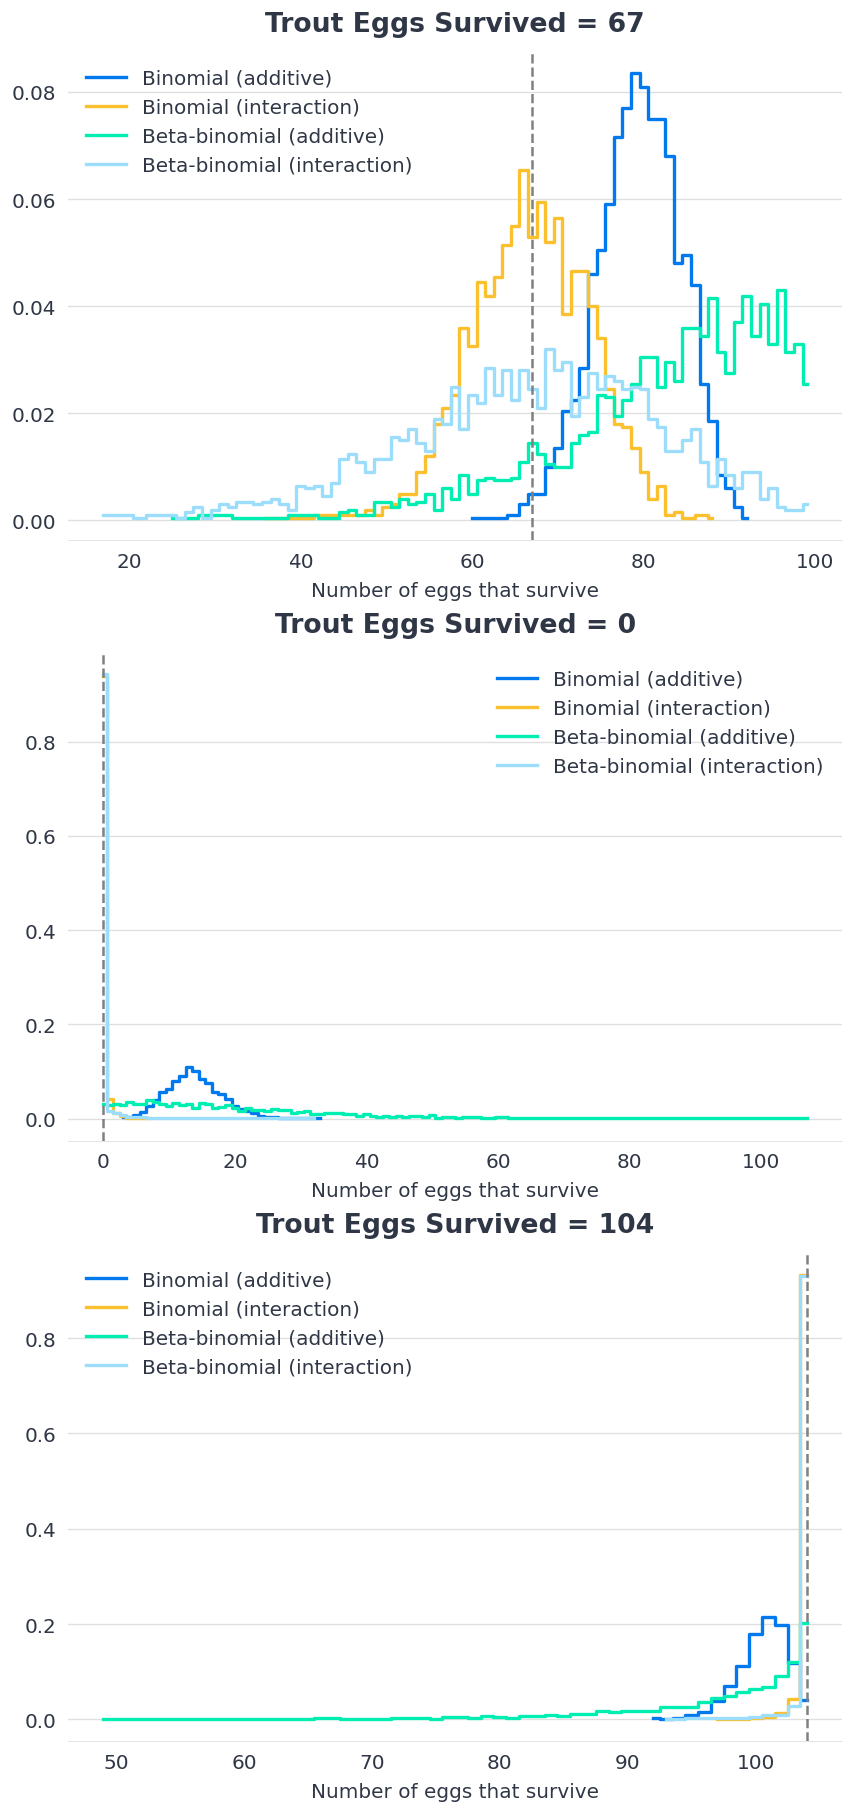

In [37]:
labels = [
    "Binomial (additive)", 
    "Binomial (interaction)",
    "Beta-binomial (additive)",
    "Beta-binomial (interaction)"
]

pp_bin_add = pred_additive_bin_idata.posterior_predictive["p(survive, total)"].to_numpy()
pp_bin_int = pred_interaction_bin_idata.posterior_predictive["p(survive, total)"].to_numpy()
pp_bb_add = pred_additive_beta_bin_idata.posterior_predictive["p(survive, total)"].to_numpy()
pp_bb_int = pred_interaction_beta_bin_idata.posterior_predictive["p(survive, total)"].to_numpy()

y_survive = test_trout_egg["survive"].to_numpy()

fig, axes = plt.subplots(3, 1, figsize=(7, 15), layout="constrained")

for i, ax in enumerate(axes):
    values_bin_add = pp_bin_add[..., i].flatten()
    values_bin_int = pp_bin_int[..., i].flatten()
    values_bb_add = pp_bb_add[..., i].flatten()
    values_bb_int = pp_bb_int[..., i].flatten()

    arrays = [values_bin_add, values_bin_int, values_bb_add, values_bb_int]

    for label, arr in zip(labels, arrays):
        values, counts = np.unique(arr, return_counts=True)
        ax.step(values, counts / counts.sum(), where="mid", linewidth=2, label=label)

    ax.axvline(y_survive[i], ls="--", color="gray")
    ax.legend()
    ax.set(xlabel="Number of eggs that survive", title=f"Trout Eggs Survived = {y_survive[i]}");

### Discussion

 A "good" model should have the observed value in a region of non-negligible probability.

* Survival rate ~ 67%-  all the models except from the additive binomial regression result in a sensible predictive distribution. 
* Survival rate = 0, 1:
    * Both models with interaction are giving a lot of probability to the observed values.
    * The binomial additive model is the least accurate
    * the beta binomial model does a much better job in all cases, however it has (too )high variance
* In this scenario, interactive models tend to overfit, since $p \ge n$
* additive models cannot overfit $p < n$
    * adding variability can help imporve results, however increase the uncertainty (large variability)
* **Best model**- BetaBinomial with additive effects

# Identifiability
* location are period are categorical variables
* we can have unidentifiability (overparameterization) if we are not careful

In [40]:
survive = df_troutegg["survive"].to_numpy()
total = df_troutegg["total"].to_numpy()
location, location_idx = np.unique(df_troutegg["location"], return_inverse=True)
period, period_idx = np.unique(df_troutegg["period"], return_inverse=True)

coords = {
    "location": location,
    "period": period
}

### Solutions
* intercept as a baseline + zerosumnormal to both features
    * the coefficients are relative to the "global average categorical value"
    * the baseline includes "global average categorical value" from all categorial features
        * fixed effects + categorical placebo values
* intercept + pivoting to both features
    * the intercept "contains" reference (placebo) value from each category variable
        * largest intercept
    * the rest of coefficients for that feature (k-1 instead of k) are relative to the placebo value
* no intercept + zerosumnormal/pivoting to one feature
    * the feature with no constrains acts as an intercept (offset per category value), and the feature\
    with the zerosumnormal (pivoting) constraint is relative to the "global average categorical value" \
    (reference/placebo value)

In [41]:
import pytensor.tensor as pt

In [42]:
with pm.Model(coords=coords) as zerosumnormal_model:
    """intercept as baseline + zerosumnormal constraints to all (categorical) features"""
    intercept = pm.Normal("intercept")
    b_location = pm.ZeroSumNormal("b_location", dims="location")
    b_period = pm.ZeroSumNormal("b_period", dims="period")
    mu = intercept + b_location[location_idx] + b_period[period_idx]
    p = pm.math.invlogit(mu)
    pm.Binomial("survive", p=p, n=total, observed=survive)

In [43]:
with zerosumnormal_model: 
    idata = pm.sample(chains=4, random_seed=1234)
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, b_location, b_period]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.435,0.071,1.311,1.573,0.001,0.001,4053.0,3594.0,1.0
b_location[1],1.399,0.151,1.115,1.677,0.002,0.002,3792.0,3304.0,1.0
b_location[2],1.003,0.139,0.746,1.259,0.002,0.001,4734.0,3213.0,1.0
b_location[3],0.199,0.107,-0.013,0.388,0.002,0.001,4578.0,3098.0,1.0
b_location[4],0.479,0.122,0.256,0.713,0.002,0.001,4882.0,3132.0,1.0
b_location[5],-3.081,0.140,-3.364,-2.834,0.002,0.002,4023.0,3051.0,1.0
b_period[4],1.643,0.155,1.356,1.948,0.002,0.002,3866.0,3107.0,1.0
b_period[7],-0.409,0.111,-0.611,-0.191,0.002,0.001,4549.0,3447.0,1.0
b_period[8],-0.554,0.112,-0.767,-0.352,0.002,0.001,4826.0,2935.0,1.0
b_period[11],-0.679,0.103,-0.860,-0.474,0.001,0.001,5202.0,3673.0,1.0


In [44]:
with pm.Model(coords=coords) as pivot_model:
    """intercept + pivoting features"""
    intercept = pm.Normal("intercept")

    b_location_reduced = pm.Normal("b_location_reduced", shape=len(location) - 1)
    # set the first location as the refernce value
    b_location = pm.Deterministic("b_location", pt.concatenate([pt.zeros(1), b_location_reduced]), dims="location")

    b_period_reduced = pm.Normal("b_period_reduced", shape=len(period) - 1)
    # set the first period as the refernce value
    b_period = pm.Deterministic("b_period", pt.concatenate([pt.zeros(1), b_period_reduced]), dims="period")

    mu = intercept + b_location[location_idx] + b_period[period_idx]
    p = pm.math.invlogit(mu)
    pm.Binomial("survive", p=p, n=total, observed=survive)

In [45]:
with pivot_model:
    idata = pm.sample(chains=4, random_seed=1234)
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [intercept, b_location_reduced, b_period_reduced]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,3.931,0.235,3.507,4.391,0.007,0.005,1118.0,1526.0,1.0
b_location_reduced[0],-0.122,0.219,-0.549,0.272,0.005,0.004,1823.0,2420.0,1.0
b_location_reduced[1],-0.935,0.192,-1.302,-0.584,0.005,0.004,1491.0,2006.0,1.0
b_location_reduced[2],-0.647,0.202,-1.016,-0.273,0.005,0.003,1710.0,2239.0,1.0
b_location_reduced[3],-4.098,0.211,-4.486,-3.696,0.006,0.004,1432.0,2010.0,1.0
b_period_reduced[0],-1.739,0.208,-2.135,-1.352,0.005,0.004,1622.0,2034.0,1.0
b_period_reduced[1],-1.880,0.214,-2.256,-1.451,0.006,0.004,1476.0,1974.0,1.0
b_period_reduced[2],-1.996,0.203,-2.358,-1.616,0.005,0.004,1507.0,2053.0,1.0
b_location[1],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
b_location[2],-0.122,0.219,-0.549,0.272,0.005,0.004,1823.0,2420.0,1.0


In [49]:
with pm.Model(coords=coords) as zerosum_and_no_intercept_model:
    b_location = pm.Normal("b_location", dims="location")
    b_period = pm.ZeroSumNormal("b_period", dims="period")
    mu = b_location[location_idx] + b_period[period_idx]
    p = pm.math.invlogit(mu)
    pm.Binomial("survive", p=p, n=total, observed=survive)

In [50]:
with zerosum_and_no_intercept_model:
    idata = pm.sample(chains=4, random_seed=1234)
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b_location, b_period]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_location[1],2.793,0.185,2.454,3.151,0.003,0.002,4431.0,3022.0,1.0
b_location[2],2.405,0.160,2.119,2.713,0.002,0.002,4955.0,3391.0,1.0
b_location[3],1.613,0.121,1.382,1.831,0.002,0.001,4554.0,3122.0,1.0
b_location[4],1.895,0.138,1.635,2.147,0.002,0.001,4479.0,3111.0,1.0
b_location[5],-1.665,0.145,-1.942,-1.407,0.002,0.002,4379.0,3192.0,1.0
b_period[4],1.625,0.154,1.347,1.921,0.003,0.002,3344.0,3243.0,1.0
b_period[7],-0.404,0.109,-0.608,-0.197,0.002,0.001,4503.0,3242.0,1.0
b_period[8],-0.552,0.112,-0.757,-0.345,0.002,0.001,4180.0,3165.0,1.0
b_period[11],-0.670,0.104,-0.864,-0.472,0.001,0.001,5290.0,3582.0,1.0
